In [1]:
import sncosmo
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
import seaborn as sns

sns.set(style='whitegrid')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

## Comentários

Estou testando cortar partes dos filtros pros modelos falharem menos.

Algumas SNe estão repetidas. Não há ajuste duplicado porque há uma ordem para checar se existem os arquivos, então o último a ser checado é o ajustado. Mas isso é um problema a ser observado.

A covariância afeta bastante o resultado do CHISQ inclusive para o SALT2 e SALT2 cortado, então acho que podemos ser flexíveis nesse corte ou melhorar o modelo da covariância do EXP.

Consertar se ndof=0, não uncluir o ajuste.

Me parece que os ajustes, principalmente do EXP ATUAL tem muitos artefatos.

## Recuperando curvas de luz

In [2]:
path="./light_curves/Pantheon/Pantheon_HST_TEXT/"

In [3]:
l=[]
with open(path+"Pantheon_HST_TEXT.README",'r') as f:
    for line in f:
        l.append(line.split())

In [4]:
sne_pass_cut=[l[8:35][i][0] for i in range(0,len(l[8:35]))]

In [5]:
len(sne_pass_cut)

27

## Decodificando filtros

In [6]:
filters_dict={"candles":{"a":"ACS_WFC_F435W",
                         "b":"ACS_WFC_F475W",
                         "c":"ACS_WFC_F606W",
                         "d":"ACS_WFC_F625W",
                         "e":"ACS_WFC_F775W",
                         "f":"ACS_WFC_F814W",
                         "g":"ACS_WFC_F850LP",
                         "h":"WFC3_UVIS_F225W",
                         "i":"WFC3_UVIS_F275W",
                         "j":"WFC3_UVIS_F336W",
                         "k":"WFC3_UVIS_F390W",
                         "l":"WFC3_UVIS_F350LP",
                         "m":"WFC3_IR_F105W",
                         "n":"WFC3_IR_F110W",
                         "o":"WFC3_IR_F125W",
                         "p":"WFC3_IR_F140W",
                         "q":"WFC3_IR_F160W",
                         "r":"WFC3_IR_F098M",
                         "s":"WFC3_IR_F127M",
                         "t":"WFC3_IR_F139M",
                         "u":"WFC3_IR_F153M"},
                "goods":{"v":"F110W_NIC2",
                         "w":"F160W_NIC2",
                         "x":"F606W_ACS",
                         "y":"F675W_WFPC2",
                         "z":"F775W_ACS",
                         "A":"F814W_WFPC2",
                         "B":"F850LP_ACS",
                          "C":"F110W_NIC2",
                          "D":"F775W_ACS",
                          "E":"F850LP_ACS",
                          "F":"NIC3.F110r", # n tem .dat
                          "G":"NIC3.F160r", # n tem .dat
                          "H":"wfpc2.f814w.092003r",
                          "I":"F110W_NIC2",
                          "J":"newh_nirc2",
                          "K":"F775W_ACS",
                          "L":"F850LP_ACS"}}

In [7]:
path_f_can="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/HST/HST_Candles/"
path_f_goods="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/HST/HST_GOODS/"

## Registrando filtros e criando sistema de magnitude composto

In [8]:
ab = sncosmo.get_magsystem('ab')

In [9]:
for surv in filters_dict:
    if surv=="candles":
        for filt in filters_dict[surv].values():
            wave = pd.read_csv(path_f_can+filt+".dat",header=None,sep="\s+",comment="#")[0].values
            trans = pd.read_csv(path_f_can+filt+".dat",header=None,sep="\s+",comment="#")[1].values
            band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
            sncosmo.registry.register(band,force=True)
    if surv=="goods":
        for filt in filters_dict[surv].values():
            if filt in ["NIC3.F110r","NIC3.F160r"]:
                wave = pd.read_csv(path_f_goods+filt,header=None,sep="\s+",comment="#")[0].values
                trans = pd.read_csv(path_f_goods+filt,header=None,sep="\s+",comment="#")[1].values
                band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
                sncosmo.registry.register(band,force=True)
            else:
                wave = pd.read_csv(path_f_goods+filt+".dat",header=None,sep="\s+",comment="#")[0].values
                trans = pd.read_csv(path_f_goods+filt+".dat",header=None,sep="\s+",comment="#")[1].values
                band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
                sncosmo.registry.register(band,force=True)

In [10]:
magsystem = {"candles":{"candles_ACS_WFC_F435W":('ab',0.),
                      "candles_ACS_WFC_F475W":('ab',0.),
                      "candles_ACS_WFC_F606W":('ab',0.),
                      "candles_ACS_WFC_F625W":('ab',0.),
                      "candles_ACS_WFC_F775W":('ab',0.),
                      "candles_ACS_WFC_F775W":('ab',0.),
                      "candles_ACS_WFC_F814W":('ab',0.),
                      "candles_ACS_WFC_F850LP":('ab',0.),
                      "candles_WFC3_UVIS_F225W":('ab',0.),
                      "candles_WFC3_UVIS_F275W":('ab',0.),
                      "candles_WFC3_UVIS_F336W":('ab',0.),
                      "candles_WFC3_UVIS_F390W":('ab',0.),
                      "candles_WFC3_UVIS_F350LP":('ab',0.),
                      "candles_WFC3_IR_F105W":('ab',0.),
                      "candles_WFC3_IR_F110W":('ab',0.),
                      "candles_WFC3_IR_F125W":('ab',0.),
                      "candles_WFC3_IR_F140W":('ab',0.),
                      "candles_WFC3_IR_F160W":('ab',0.),
                      "candles_WFC3_IR_F098M":('ab',0.),
                      "candles_WFC3_IR_F127M":('ab',0.),
                      "candles_WFC3_IR_F139M":('ab',0.),
                      "candles_WFC3_IR_F153M":('ab',0.)},
             "goods":{"goods_F110W_NIC2":('ab',0.),
                      "goods_F160W_NIC2":('ab',0.),
                      "goods_F606W_ACS":('ab',0.),
                      "goods_F675W_WFPC2":('ab',0.),
                      "goods_F775W_ACS":('ab',0.),
                      "goods_F814W_WFPC2":('ab',0.),
                      "goods_F850LP_ACS":('ab',0.),
                      "goods_NIC3.F110r":('ab',0.),
                      "goods_NIC3.F160r":('ab',0.),
                      "goods_wfpc2.f814w.092003r":('ab',0.),
                      "goods_newh_nirc2":('ab',0.)}}

## Ajustando curvas de luz

In [11]:
def lc_fit(sn):    

    if os.path.exists(path+"HST_"+sn+".DAT")==True:
        meta, tables = sncosmo.read_snana_ascii(path+"HST_"+sn+".DAT", default_tablename='OBS') 
        surv="goods"
    elif os.path.exists(path+"htHST_CANDELS1_"+sn.lower()+".dat")==True:
        meta, tables = sncosmo.read_snana_ascii(path+"htHST_CANDELS1_"+sn.lower()+".dat", default_tablename='OBS') 
        surv="candles"
    else:
        return print(f"File not found for SN {sn}")
    
    dat=tables["OBS"]

    dat.add_column([surv+"_"+filters_dict[surv][f] for f in dat["FLT"]], name='FILTER') # decodificando
    dat.remove_column("FLT")

    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])

    magsys=sncosmo.CompositeMagSystem(bands=magsystem[surv],name="magsys")
    sncosmo.register(magsys,force=True)
        
    try:
        dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])
        dat["FLUX"]=[magsys.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
        dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    except:
        dat["MAG"]=-2.5*np.log10(dat["FLUXCAL"])+27.5
        dat["MAGERR"]=abs(2.5*np.log10(np.e)*dat["FLUXCALERR"]/dat["FLUXCAL"])
        dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])
        dat["FLUX"]=[ab.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
        dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]

    rm_f=[]
    if sn=="Primo":
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F814W")[0])
        rm_f=["candles_ACS_WFC_F814W"]
        
    if sn=="colfax":
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F814W")[0])
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F850LP")[0])
        rm_f=["candles_ACS_WFC_F814W","candles_ACS_WFC_F850LP"]
    
    if sn=="Lancaster":
        dat.remove_rows(np.where(dat["FILTER"]=="F160W_NIC2")[0])
        rm_f=["F160W_NIC2"]

    dat.remove_columns(["FIELD","MAG","MAGERR"])
     
    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
    
    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]
    dat.add_column("magsys", name='ZPSYS')
    
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
    
    model = sncosmo.Model(source='salt2',effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(mwebv=meta["MWEBV"],z=meta["REDSHIFT_FINAL"]) 
    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0', 'x0', 'x1', 'c'],modelcov=True, phase_range=(-15, 45.), wave_range=(3000.,7000.), verbose=False)
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, rm_f, dat, result, fitted_model

In [12]:
pp = PdfPages("./lc_fit_plot_SALT2_HST_Pantheon.pdf")

In [13]:
def lc_fit_plot(sn, surv, rm_f,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    c=round(result["parameters"][4],2)
    cerr=round(result["errors"]["c"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-10.,t0+40.,100)
    fig=plt.figure(figsize=(12,8))
    for i,f in enumerate(magsystem[surv].keys()): 
        if len(table_data[table_data["FILTER"]==f])==0:
            pass
        else:
            try:              
                if f not in rm_f:
                    plt.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color='C%i'%i)
                    plt.errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f,ls="none", marker='o',markersize=8,color='C%i'%i)
                    plt.xlabel(f"MJD-{t0}",fontsize=15)
                    plt.ylabel(r"FLUX ($Z_{AB}$=27.5)",fontsize=15)
                    plt.title(f"SALT2 fit, SN: {sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   c={c:.2f}$\pm${cerr:.2f},   mwebv={mwebv:.2f}",fontsize=15)
                    plt.xlim(-12,42)
                    plt.legend(fontsize=15)
                else: 
                    continue
            except:
                print(f"Filter {f} of sn {sn} not defined.")
                continue
    pp.savefig()
    plt.close(fig)
    #plt.show()

In [14]:
 def return_fit_data(meta,res,model_name):
    free_par=(list(res.errors.keys()))

    return [meta["SNID"], meta["SURVEY"], meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors[free_par[0]], res.parameters[2], res.errors[free_par[1]], res.parameters[3],
           res.errors[free_par[2]], res.parameters[4], res.errors[free_par[3]],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [15]:
all_fit_data=[]
f=open("./lc_failed_fits_SALT2_HST_Pantheon.txt","w")
i=0
for sn in sne_pass_cut:
    meta, surv, rm_f, table_data, result, fitted_model=lc_fit(sn) 
    
    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(meta,result,"SALT2_ORI"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")

    lc_fit_plot(sn, surv, rm_f, table_data, result, fitted_model)                       

/home/cassia/miniconda3/envs/sne/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F606W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


Filter candles_ACS_WFC_F606W of sn carter not defined.


In [16]:
pp.close()

In [17]:
f.close()

## Salvando dados dos ajustes

In [18]:
df=pd.DataFrame(all_fit_data)

In [19]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [20]:
df["mB"]=-2.5*np.log10(df["X0"])+10.635  # Mosher 2014
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

In [21]:
df.to_csv("./lc_fit_results_SALT2_HST_Pantheon.txt", sep=' ', index=False)

## Análises dos Ajustes

In [22]:
df_salt2_bf_cuts=df[df["MODEL"]=="SALT2_ORI"].reset_index(drop=True)
df_salt2=df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.) & (abs(df["X2/C"])<=0.3) & (df["CHISQ/NDOF"]<=5.)].reset_index(drop=True)

In [23]:
passcut_salt2=len(df[df["MODEL"]=="SALT2_ORI"])
passcut_salt2_x1=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.)])
passcut_salt2_c=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X2/C"])<=0.3)])
passcut_salt2_chi2=len(df[(df["MODEL"]=="SALT2_ORI") & (df["CHISQ/NDOF"]<=5.)])

#### Checando distribuição dos parâmetros

De um total 172 SNe, 27 foram bem ajustadas.
1 não passaram no corte de |X1| < 3.
0 não passaram no corte de |C| < 0.3
0 não passaram no corte de Chi2 < 5.
No final ficamos com 26 Sne.


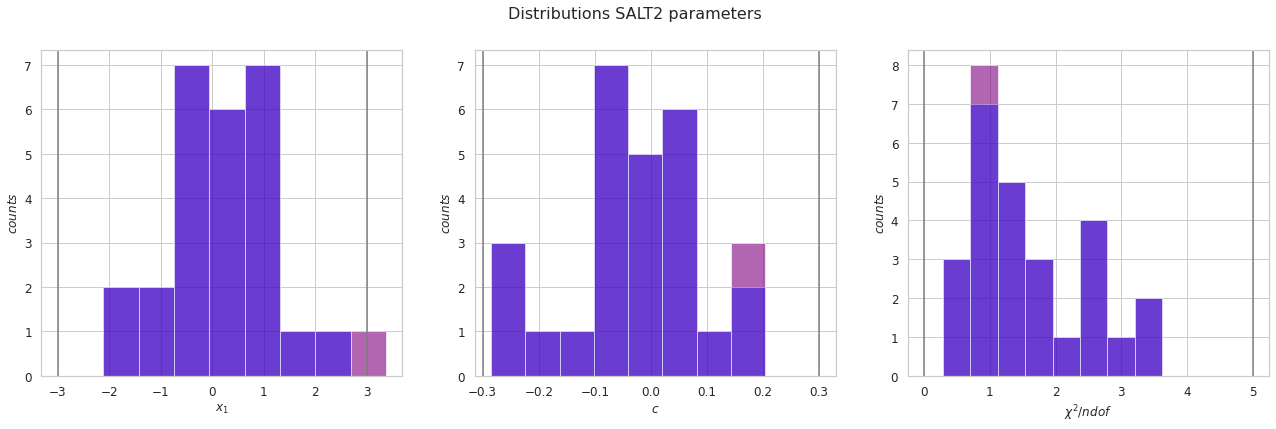

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Distributions SALT2 parameters",fontsize=16)

bins = 8
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],color="purple",bins=bins,alpha=0.6)
ax1.hist(df_salt2["X1"],color="blue",bins=bins,alpha=0.4)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$counts$")
ax1.axvline(3.,c="gray")
ax1.axvline(-3.,c="gray")

bins = 8
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,color="purple",alpha=0.6)
ax2.hist(df_salt2["X2/C"],color="blue",alpha=0.4,bins=bins)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel(r"$counts$")
ax2.axvline(0.3,c="gray")
ax2.axvline(-0.3,c="gray")

bins = 8
bins = np.histogram(np.hstack((df_salt2_bf_cuts["CHISQ/NDOF"], df_salt2["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_salt2_bf_cuts["CHISQ/NDOF"],bins=bins,color="purple",alpha=0.6)
ax3.hist(df_salt2["CHISQ/NDOF"],bins=bins,color="blue",alpha=0.4)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel(r"$counts$")
ax3.axvline(0.,c="gray")
ax3.axvline(5.,c="gray")

print(f"De um total 172 SNe, {passcut_salt2} foram bem ajustadas.")
print(f"{passcut_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{passcut_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"{passcut_salt2-passcut_salt2_chi2} não passaram no corte de Chi2 < 5.")
print(f"No final ficamos com {len(df_salt2)} Sne.")

#### Checando correlação entre os parâmetros

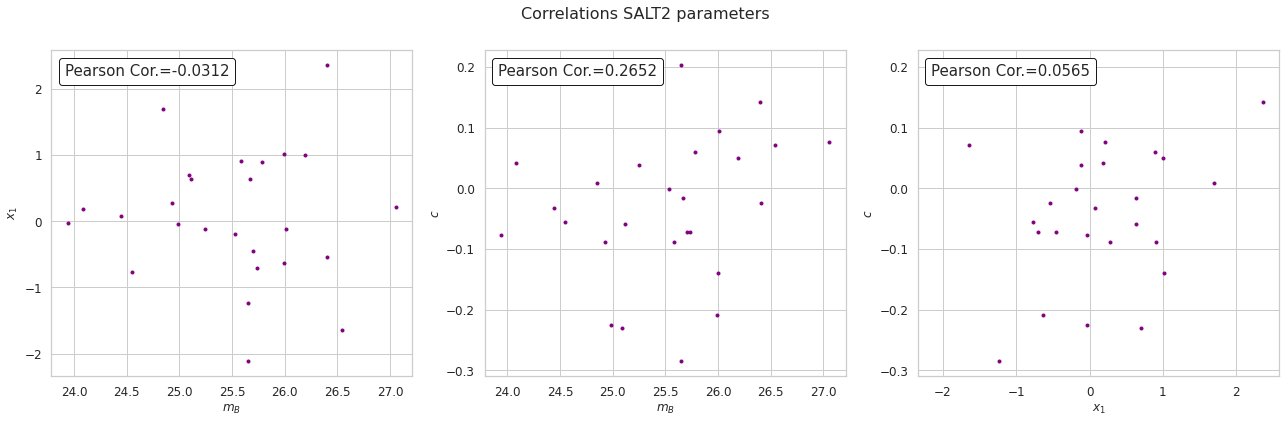

In [25]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Correlations SALT2 parameters",fontsize=16)

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="purple")
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="purple")
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$c$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="purple")
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$c$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);